In [285]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras
from sklearn.preprocessing import StandardScaler, PowerTransformer, MaxAbsScaler, Normalizer, RobustScaler, minmax_scale, QuantileTransformer

In [286]:
dataset = pd.read_csv('historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [339]:
trainSet = dataset['2017-06-01':'2017-12-31'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

In [95]:
symbols = trainSet.ticker.unique()

In [289]:
timesteps = 60
def make_samples(data, s):
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data)
    for i in range(timesteps, l):
        x_y = []
        x = data[i-timesteps: i, 0]
        x_y = [i for i in x]   
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    k = data[i+j-1,0]
                    x_y.append(k)
                    X_Y = np.array(x_y)
                    k = k.reshape(-1,1)
                    x = x.reshape(-1,1)
                    X_Y = X_Y.reshape(-1,1)
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.fit(X_Y)
                    train_set[s]['X'][j].append(sc.transform(x))
                    train_set[s]['Y'][j].append(sc.transform(k))
                    if k == data[l-1,0]:
                        stop_append[j] =True

In [340]:
# Define train_set
train_set = {}
prediction_intervals = [1,3,5,10]
for s in symbols:
    train_set.update({s:{
        'X':{},
        'Y':{}
    }})
    for i in prediction_intervals:
        train_set[s]['X'][i] = []
        train_set[s]['Y'][i] = []
    train_stock = trainSet.loc[trainSet['ticker'] == s][['adj_close']].values
    make_samples(train_stock, s)

In [341]:
for s in train_set:
    for i in train_set[s]['X']:
        x_train = train_set[s]['X'][i]
        y_train = train_set[s]['Y'][i]
        train_set[s]['X'][i] = np.array(x_train)
        train_set[s]['Y'][i] = np.array(y_train)

In [342]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=2, mode='min')

In [343]:
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    
    regressorGRU.add(GRU(units = 30, return_sequences = False, input_shape=(60,1), activation='tanh'))
    regressorGRU.add(Dropout(0.3))
    
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

In [344]:
model = {}
model_history = {}
for i in [1,10]:
    model[i] = make_gru_network()
    model[i].compile(optimizer='rmsprop', loss='mean_squared_error')
    
    n_epoch = 100
    x_train = []
    y_train = []
    
    for s in train_set:
        for j in train_set[s]['X'][i]:
            x_train.append(j)
        for j in train_set[s]['Y'][i]:
            y_train.append(j)
    X_train, Y_train = np.array(x_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    Y_train = Y_train.reshape(Y_train.shape[0])
    
    print(X_train.shape, Y_train.shape)
    print('Fitting prediction interval {}  model'.format(i))
    model_history[i] = model[i].fit(X_train, Y_train, epochs = n_epoch, batch_size = 6000, 
                                    validation_split = 0.3,callbacks=[es])

(418324, 60, 1) (418324,)
Fitting prediction interval 1  model
Train on 292826 samples, validate on 125498 samples
Epoch 1/100
292826/292826 [==============================] - 10s 33us/step - loss: 0.2275 - val_loss: 0.0456
Epoch 2/100
292826/292826 [==============================] - 6s 21us/step - loss: 0.0464 - val_loss: 0.0246
Epoch 3/100
292826/292826 [==============================] - 6s 21us/step - loss: 0.0286 - val_loss: 0.0178
Epoch 4/100
292826/292826 [==============================] - 6s 21us/step - loss: 0.0222 - val_loss: 0.0144
Epoch 5/100
292826/292826 [==============================] - 6s 21us/step - loss: 0.0193 - val_loss: 0.0135
Epoch 6/100
292826/292826 [==============================] - 6s 21us/step - loss: 0.0178 - val_loss: 0.0128
Epoch 7/100
292826/292826 [==============================] - 6s 21us/step - loss: 0.0169 - val_loss: 0.0123
Epoch 8/100
292826/292826 [==============================] - 6s 21us/step - loss: 0.0164 - val_loss: 0.0117
Epoch 9/100
292826/2

In [299]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [298]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

In [345]:
def make_test_data(s):
    scaler = {s:{}}
    test_set = {s:{}}

    test_set.update({s:{
            'X':{},
            'Y':{}
        }})
    for i in prediction_intervals:
            test_set[s]['X'][i] = []
            test_set[s]['Y'][i] = []
            scaler[s][i] = []

    test_stock = testSet.loc[testSet['ticker'] == s][['adj_close']].values

    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(test_stock)

    for i in range(timesteps, l):
        x_y = []
        x = test_stock[i-timesteps: i, 0]
        x_y = [i for i in x]   
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    k = test_stock[i+j-1,0]
                    x_y.append(k)
                    X_Y = np.array(x_y)
                    k = k.reshape(-1,1)
                    x = x.reshape(-1,1)
                    X_Y = X_Y.reshape(-1,1)
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.fit(X_Y)
                    test_set[s]['X'][j].append(sc.transform(x))
                    test_set[s]['Y'][j].append(k)
                    if k == test_stock[l-1,0]:
                        stop_append[j] =True
                scaler[s][j].append(sc)
                
    return test_set, scaler

In [346]:
def make_prediction(data, s, scaler):
    mse_val = {}
    y_true_val = {}
    y_pred_val = {}
    for i in [1,10]:
        x_test = []    
        for j in data[s]['X'][i]:
                x_test.append(j)
        X_test = np.array(x_test)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        result = model[i].predict(X_test)
        y_pred = []
        for j in range(0,len(result)):
            y = result[j]
            y = y.reshape(-1,1)
            k = scaler[s][i][j].inverse_transform(y)
            y_pred.append(k[0][0])

        y_test = data[s]['Y'][i]
        y_true = np.array(y_test)
        y_true = y_true.reshape(y_true.shape[0])
        
        y_true_val[i] = y_true
        y_pred_val[i] = y_pred

        mse_val[i] = return_mse(y_true, y_pred) 
    return y_true_val, y_pred_val, mse_val

In [394]:
s = 'A'
data, sc = make_test_data(s)
y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)

In [395]:
for i in mse_val:
    print('Test Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Test Set -> MSE of A inveral 1: 1.1258227475914682
Test Set -> MSE of A inveral 10: 3.9629326494663406


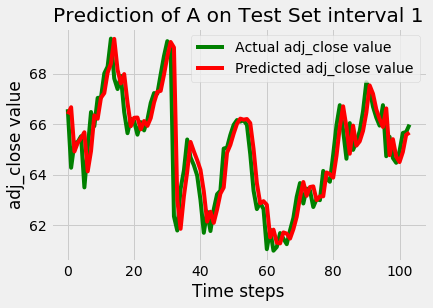

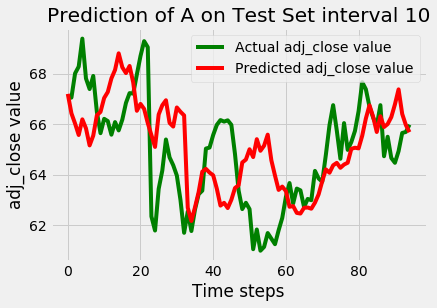

In [396]:
for i in [1,10]:
    plotting_graph(y_true_val[i], y_pred_val[i], s, 'Test Set interval {}'.format(i))